In [16]:
%load_ext autoreload
%autoreload 2
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice
from collections import defaultdict, Counter
from analysis_utils import get_data
from learning_utils import pickle_load, pickle_save, construct_pipeline, Participant, get_normalized_features,\
                            get_normalized_feature_values, construct_reward_function, reward_levels, reward_type, \
                            construct_repeated_pipeline, create_dir, get_strategy_counts, get_cluster_dict, \
                            get_modified_weights
from sequence_utils import compute_average_click_likelihoods
from generic_mouselab import GenericMouselabEnv
from modified_mouselab import TrialSequence, reward_val, normal_reward_val, constant_reward_val, decreasing_reward_val
from planning_strategies import strategy_dict
from rl_models import models as rl_models
from computational_microscope import ComputationalMicroscope
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy.linalg as LA
from scipy.special import softmax
from IPython.core.display import display, HTML
from experiment_utils import Experiment
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["axes.grid"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_ds_weights(weights, features, feature_systems, decision_systems):
    ds_weights = defaultdict(int)
    for (f, w) in zip(features, weights):
        if feature_systems[f] == 'stopping_criteria' or f == "soft_pruning" or f == "termination_constant" or f=="is_previous_successor_negative":
            ds_weights[feature_systems[f]] += -w
        else:
            ds_weights[feature_systems[f]] += w
    return [ds_weights[ds] for ds in decision_systems]

def get_ds_proportions(W_DS):
    DS_proportions = np.zeros_like(W_DS)
    for i in range(DS_proportions.shape[0]):
        total_w = np.sum([abs(w) for w in W_DS[i]])
        if total_w != 0:
            DS_proportions[i] = abs(W_DS[i])/total_w
    return DS_proportions

### Verifying which model wins the most for all distances

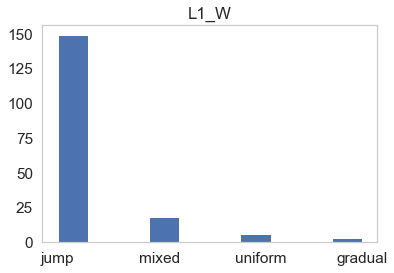

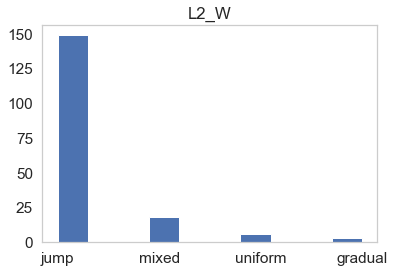

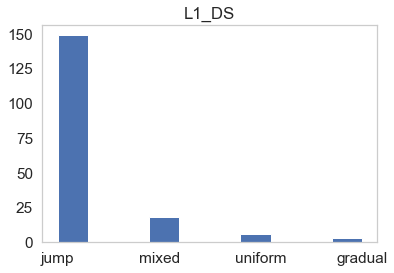

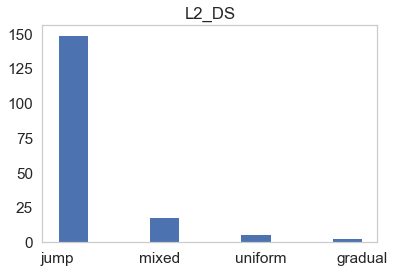

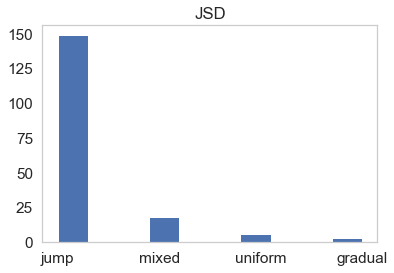

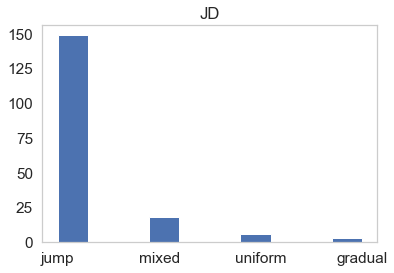

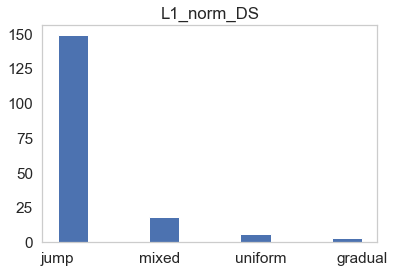

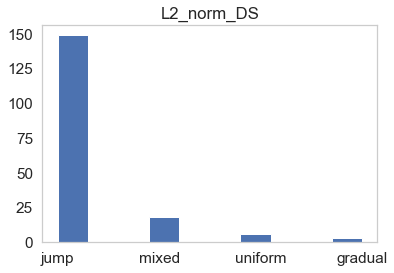

In [70]:
prior_transitions_v1 = pickle_load("data/prior_transitions_v1.pkl")
distances = ["L1_W", "L2_W", "L1_DS", "L2_DS", "JSD", "JD", "L1_norm_DS", "L2_norm_DS"]
distance_models = {}
for distance in distances:
    models = []
    for k in prior_transitions_v1[distance].keys():
        seq, T, transition_T, model = prior_transitions_v1[distance][k]
        models.append(model)
    distance_models[distance] = models
for distance in distances:
    plt.figure()
    plt.title(distance)
    plt.hist(models)

In [28]:
features = pickle_load("data/microscope_features.pkl")
decision_systems = pickle_load("data/decision_systems.pkl")

feature_systems = pickle_load("data/feature_systems.pkl")
decision_system_features = pickle_load("data/decision_system_features.pkl")
DS_proportions = pickle_load("data/strategy_decision_proportions.pkl")

strategy_weights = pickle_load("data/microscope_weights.pkl")
W_DS = pickle_load("data/strategy_decision_weights.pkl")

L1_DS = pickle_load("data/L1_DS.pkl")
L2_DS = pickle_load("data/L2_DS.pkl")
L1_norm_DS = pickle_load("data/L1_norm_DS.pkl")
L2_norm_DS = pickle_load("data/L2_norm_DS.pkl")

L1_distances = pickle_load("data/L1_distances.pkl")
L2_distances = pickle_load("data/L2_distances.pkl")
jeffreys_divergence = pickle_load("data/jeffreys_divergences.pkl")
jsd = pickle_load("data/js_divergences.pkl")

strategy_space = pickle_load("data/strategy_space.pkl")
num_strategies = len(strategy_space)
strategy_feature_scores = pickle_load("data/strategy_feature_scores.pkl") # Average scores using feature based representation of the strategies
strategy_scores = pickle_load("data/strategy_scores.pkl") # Average scores using an algorithmic representation of the strategies

clusters = pickle_load("data/kl_clusters.pkl")
cluster_map = pickle_load("data/kl_cluster_map.pkl")

cluster_scores = pickle_load("data/cluster_scores.pkl")

### Partitioning the set of strategies into quartiles according a decision system

In [35]:
from scipy.stats.mstats import mquantiles
temp_DS_proportions = DS_proportions[[s-1 for s in strategy_space], :]
decision_proportion_df = pd.DataFrame(temp_DS_proportions, columns = decision_systems)
pd.options.display.max_rows = 1000
decision_quantiles = decision_proportion_df.quantile([0.33, 0.67], axis = 0)
max_proportions = decision_proportion_df.max()
strategies_by_level = {}
for ds in decision_systems:
    df = decision_proportion_df[ds].tolist()
    qs = mquantiles(df, prob=[0.33, 0.67])
    vals = [*qs, max_proportions[ds]]
    level_indices = [0]
    for i in range(0, len(vals) - 1):
        if vals[i] != vals[i+1]:
            level_indices.append(i+1)
    min_val = -1
    total_partitions = []
    for i in level_indices:
        partition = []
        max_val = vals[i]
        for s, val in enumerate(df):
            if val > min_val and val <= max_val:
                partition.append(strategy_space[s])
        total_partitions.append(partition)
        min_val = max_val
    strategies_by_level[ds] = total_partitions

In [74]:
print(strategies_by_level)

{'mental_effort_avoidance': [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 78, 80, 82, 85, 86, 87, 88, 89], [1, 18, 30, 45, 66, 76, 79, 84]], 'model_based': [[2, 5, 6, 7, 8, 9, 11, 12, 13, 15, 18, 23, 24, 30, 31, 33, 36, 37, 39, 42, 48, 49, 54, 61, 62, 63, 64, 67, 69, 71, 74, 75, 76, 78, 79, 80, 87], [16, 27, 28, 29, 41, 44, 45, 47, 57, 60, 65, 66, 70, 86, 88, 89], [1, 3, 4, 10, 14, 17, 21, 22, 26, 32, 34, 40, 43, 46, 50, 51, 53, 55, 56, 58, 59, 72, 73, 82, 84, 85]], 'pavlovian': [[2, 3, 4, 5, 6, 7, 10, 11, 12, 23, 24, 26, 27, 30, 31, 32, 33, 36, 39, 40, 46, 47, 48, 49, 53, 54, 55, 56, 60, 61, 62, 63, 66, 71, 72, 73, 74, 78, 79, 82, 85, 86, 87, 88], [1, 8, 9, 13, 37, 45, 59, 64, 84], [14, 15, 16, 17, 18, 21, 22, 28, 29, 34, 41, 42, 43, 44, 50, 51, 57, 58, 65, 67, 69, 70, 75, 76, 80, 89]], '

### Validation of decision systems

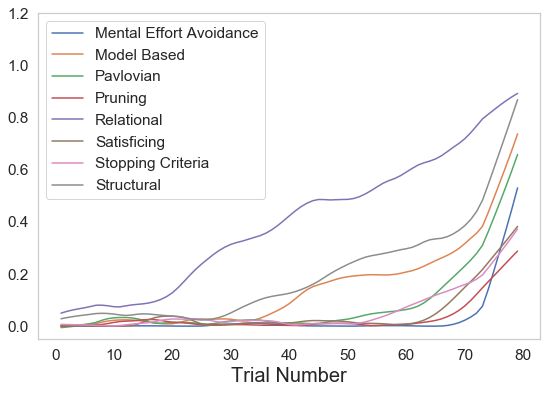

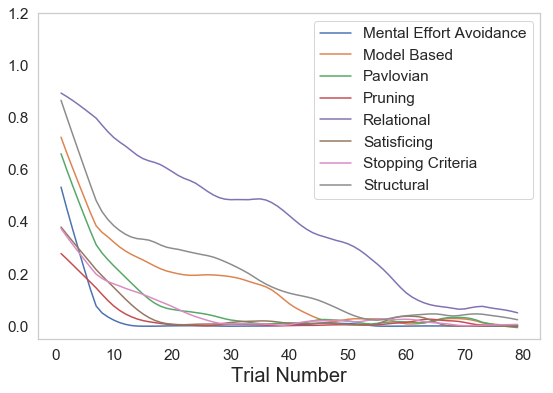

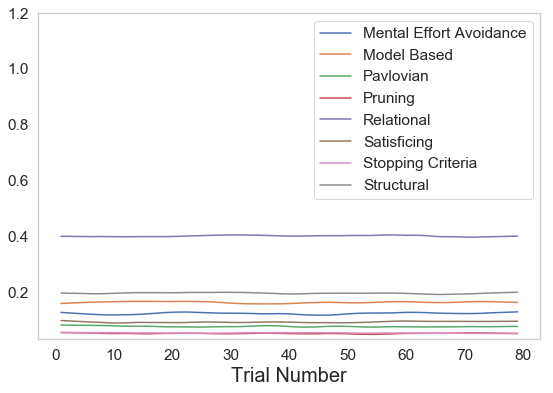

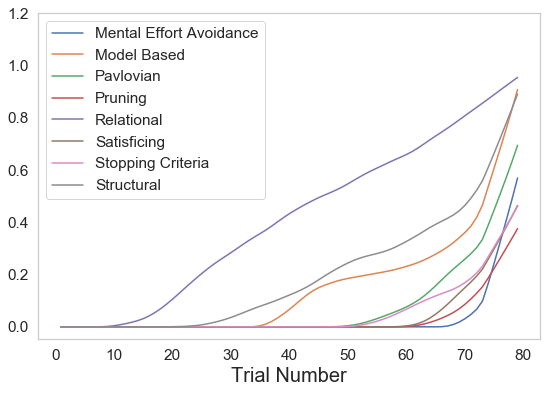

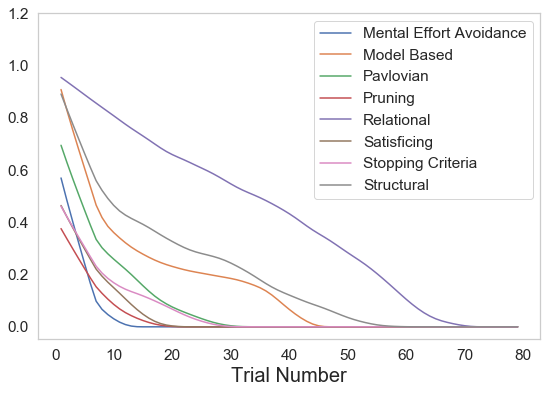

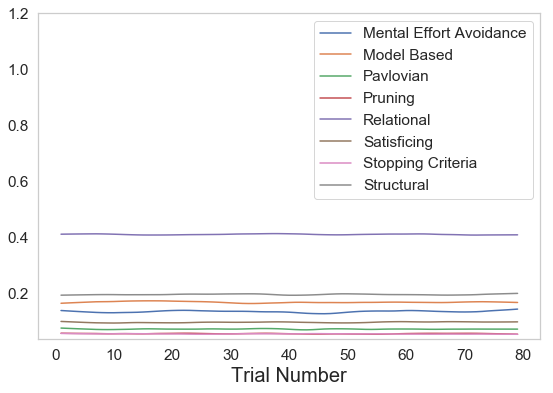

In [87]:
from learning_utils import smoothen
ds_validation_sequences = pickle_load("data/ds_validation_sequences.pkl")
trends = ["inc", "dec", "const"]
trend_labels = ["Increasing", "Decreasing", "Constant"]
num_seq = 500
num_decision_systems = len(decision_systems)
trend_inferred = defaultdict(lambda: defaultdict(list))
trend_actual = defaultdict(lambda: defaultdict(list))
for trend in trends:
    for decision_system_index in range(len(decision_systems)):
        for run_num in range(num_seq):
            inferred, actual = ds_validation_sequences[decision_system_index][trend][run_num]
            ds_validation_sequences[decision_system_index][trend].append((inferred, actual))
            inferred_props = [DS_proportions[s-1][decision_system_index] for s in inferred]
            actual_props = [DS_proportions[s-1][decision_system_index] for s in actual]
            trend_inferred[trend][decision_systems[decision_system_index]].append(inferred_props)
            trend_actual[trend][decision_systems[decision_system_index]].append(actual_props)
for trend in trends:
    for decision_system in decision_systems:
        trend_inferred[trend][decision_system] = np.mean(trend_inferred[trend][decision_system], axis = 0)
        trend_actual[trend][decision_system] = np.mean(trend_actual[trend][decision_system], axis = 0)
        
decision_system_labels = [" ".join([str(l.capitalize()) for l in d.split("_")]) for d in decision_systems]
create_dir("results/decision_system_validation_plots")
figure_size = (9, 6)
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_inferred[trend][decision_system]) # Change this later if smoothening is not required
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    #plt.title(trend_labels[trend_index])
    plt.xlabel("Trial Number", fontsize=20)
    #plt.ylabel("Relative Influence of decision system", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_inferred.png", bbox_inches='tight')
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_actual[trend][decision_system]) # Change this later if smoothening is not required
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    #plt.title(trend_labels[trend_index])
    plt.xlabel("Trial Number", fontsize=20)
    #plt.ylabel("Relative Influence of decision system", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_actual.png", bbox_inches='tight')

### Validation

In [82]:
def get_standard_error(vals):
    std = np.std(vals)
    return np.round(std/np.sqrt(len(vals)), 3)

In [83]:
def get_confusion(s_true, s_pred):
    unique_true_s = np.unique(s_true + s_pred)
    unique_true_s.sort()
    num_unique = unique_true_s.shape[0]
    s_index = {s:i for i,s in enumerate(unique_true_s)}
    confusion_matrix = np.zeros((num_unique, num_unique))
    for t,p in zip(s_true, s_pred):
        confusion_matrix[s_index[t]][s_index[p]] += 1
    return confusion_matrix

def get_accuracy(confusion_matrix):
    counts = []
    total_count = np.sum(confusion_matrix)
    for k in range(confusion_matrix.shape[0]):
        counts.append(confusion_matrix[k][k])
    return np.round(np.sum(counts)/total_count, 3)
        
def get_confusions(s_true, s_pred, cluster_map):
    strategy_confusion = get_confusion(s_true, s_pred)
    c_true = [cluster_map[s+1] for s in s_true]
    c_pred = [cluster_map[s+1] for s in s_pred]
    cluster_confusion = get_confusion(c_true, c_pred)
    return strategy_confusion, cluster_confusion

In [84]:
def get_proportion_confusion(confusion_matrix, strategy_space): # We need inferred wrt true
    num_categories = confusion_matrix.shape[0]
    proportion_confusion = {}
    for i in range(num_categories):
        num_counts = confusion_matrix[:, i]
        num_counts = num_counts/num_counts.sum()
        proportion_confusion[strategy_space[i]] = {strategy_space[j]:np.round(c,3) for j,c in enumerate(num_counts)}
    return proportion_confusion

#### Mechanisms

In [85]:
def compute_average_confusion_index(strategy_confusion):
    indexes = []
    modified_jd = jeffreys_divergence[[s-1 for s in strategy_space], :]
    for i in range(strategy_confusion.shape[0]):
        for j in range(strategy_confusion.shape[1]):
            C = strategy_confusion[i][j] 
            if i!=j and C!=0:
                x = np.sort(modified_jd[i]).tolist()
                #print(x)
                index = x.index(modified_jd[i][j])
                #print(modified_jd[i][j], index, C)
                indexes += [index]*int(C)
    #plt.hist(indexes)
    print(np.mean(indexes), np.median(indexes))

In [86]:
def get_proportion_se(p, n):
    return np.sqrt(p*(1-p)/n)

In [94]:
strategy_validation_sequences = pickle_load("data/strategy_validation_sequences.pkl")
models = ["random", "random_switch", "gradual", "mixed", "bernoulli_rssl"]
distance = "L2_W"
num_seq = 500
for model in models:
    total_accs = []
    true_s = []
    inferred_s = []
    for i in range(num_seq):
        acc, data = strategy_validation_sequences[model][distance][i]
        strategy_validation_sequences[model][distance].append((acc, data))
        true = data[0]['s']
        inferred = data[0]['inferred']
        total_accs.append(acc)
        true_s += true
        inferred_s += inferred
    num_trials = len(inferred_s)
    strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
    proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
    proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
    print(model)#, np.round(np.mean(total_accs), 3), get_standard_error(total_accs))
    strategy_acc = get_accuracy(strategy_confusion)
    print("Strategy Accuracy", strategy_acc)
    print("Strategy Accuracy standard error", np.round(1.96*get_proportion_se(strategy_acc, num_trials),3))
    cluster_strategy_acc = get_accuracy(cluster_confusion)
    compute_average_confusion_index(strategy_confusion)
    print("Cluster Accuracy", cluster_strategy_acc)
    print("Cluster Accuracy standard error", np.round(1.96*get_proportion_se(cluster_strategy_acc, num_trials), 3), "\n")

random
Strategy Accuracy 0.757
Strategy Accuracy standard error 0.007
34.822546419098146 35.0
Cluster Accuracy 0.909
Cluster Accuracy standard error 0.005 

random_switch
Strategy Accuracy 0.88
Strategy Accuracy standard error 0.005
32.59989229940765 32.0
Cluster Accuracy 0.962
Cluster Accuracy standard error 0.003 

gradual
Strategy Accuracy 0.769
Strategy Accuracy standard error 0.007
35.19318816303741 35.0
Cluster Accuracy 0.912
Cluster Accuracy standard error 0.004 

mixed
Strategy Accuracy 0.823
Strategy Accuracy standard error 0.006
34.98615664845173 35.0
Cluster Accuracy 0.935
Cluster Accuracy standard error 0.004 

bernoulli_rssl
Strategy Accuracy 0.755
Strategy Accuracy standard error 0.007
34.48339483394834 34.0
Cluster Accuracy 0.904
Cluster Accuracy standard error 0.005 



### Strategy inferences - In sequence.

In [97]:
same_strategy_validation = pickle_load("data/same_strategy_validation.pkl")
overall_accs = []
true_s = []
inferred_s = []
num_seq = 100
for strategy in strategy_space:
    total_accs = []
    d_path = f"{dir_path}/{strategy}"
    total_s = []
    for i in range(num_seq):
        acc, data = same_strategy_validation[strategy][i]
        same_strategy_validation[strategy].append((acc, data))
        inferred_s += [s['inferred'][0] for s in data]
        true_s += [strategy-1]*len(data)
        total_accs.append(acc)
strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
pickle_save(proportion_strategy_confusion, f"data/strategy_confusions_strategy_only.pkl")
pickle_save(proportion_cluster_confusion, f"data/cluster_confusions_strategy_only.pkl")
print("Strategy Accuracy", get_accuracy(strategy_confusion))
compute_average_confusion_index(strategy_confusion)
print("Cluster Accuracy", get_accuracy(cluster_confusion), "\n")

Strategy Accuracy 0.74
34.2883295194508 34.0
Cluster Accuracy 0.897 



### Representative feature for each cluster

In [98]:
def get_cluster_feature_values(clusters, W):
    data = []
    for i, cluster in enumerate(clusters):
        for strategy in cluster:
            data.append([i] + W[strategy-1].tolist())
    return data

def get_cluster_feature_df(clusters, W, features):
    data = get_cluster_feature_values(clusters, W)
    return pd.DataFrame(data, columns=['Cluster'] + features)

def drop_nunique_columns(df):
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    df.drop(cols_to_drop, axis=1, inplace=True)
    
def get_stat_df(df):
    new_df = df.copy()
    # Base case
    if len(new_df) == 1:
        return 
    drop_nunique_columns(new_df)
    stat_df = pd.DataFrame()
    stat_df['mean'] = new_df.mean(axis=0)
    stat_df['std'] = new_df.std(axis=0)
    stat_df['mstd'] = stat_df['mean'].divide(stat_df['std'])
    stat_df['mstd'] = stat_df['mstd'].abs()
    return stat_df

In [99]:
num_clusters = np.unique(clusters).shape[0]
cluster_dict = get_cluster_dict(clusters, strategy_space)
data_df = get_cluster_feature_df([cluster_dict[v] for v in range(1, num_clusters+1)], strategy_weights, features)
for cluster_num in range(num_clusters):
    d = data_df[data_df['Cluster'] == cluster_num]
    stat_df = get_stat_df(d)
    if stat_df is not None:
        m = stat_df['mstd'].max()
        x = stat_df.loc[stat_df['mstd'].idxmax()]
        print(cluster_num, x.name, cluster_dict[cluster_num+1], len(cluster_dict[cluster_num+1]))

0 max_successor [1, 8, 9, 13] 4
1 successor_uncertainty [3, 10, 82] 3
3 siblings_count [5, 36, 37, 54, 79] 5
4 second_most_promising [4, 6, 7, 11, 12, 31, 45, 46, 47, 59, 60, 84] 12
6 uncertainty [28, 30, 34, 66] 4
7 is_root [22, 23, 32, 33, 53, 64, 65, 69, 70, 80] 10
8 successor_uncertainty [21, 40, 41, 43, 55, 56, 57, 58, 63, 67] 10
9 depth_count [16, 26, 27, 29, 44, 50, 61, 73, 78, 89] 10
12 depth [2, 14, 17, 18, 24, 39, 42, 48, 49, 62, 71, 74, 76, 85, 86, 87, 88] 17


### TODO:
1. Add clustering for decision system weights averaged for participants to see if we can get individual differences.

### Emperical data

In [100]:
features = pickle_load("data/microscope_features.pkl")
num_features = len(features)
exp_pipelines = pickle_load("data/exp_pipelines.pkl")
exp_reward_structures = {'v1.0': 'high_increasing', 'F1': 'high_increasing', 'c1.1': 'low_constant', 'T1.1': 'large_increasing'}

### For reference
v1.0 - feedback in ['action', 'meta', 'none']

F1 - condition in [0, 1, 2] which is ['action', 'meta', 'none']

c2.1 - variance in [2424, 2442]

### Using the Experiment class

In [101]:
strategy_confusions = pickle_load("data/strategy_confusions_strategy_only.pkl")
cluster_confusions = pickle_load("data/cluster_confusions_strategy_only.pkl")

In [102]:
def get_E(exp_num, increasing=False, condition='', block=''):
    pids = None
    if exp_num == "T1.1":
        block = 'test'
    exp_data = get_data(exp_num)
    participants_df = exp_data['participants']
    if 'pids' in exp_data:
        total_pids = sorted(exp_data['pids']['pids'].tolist())
    else:
        total_pids = participants_df['pid'].tolist()
    trials_data = exp_data['mouselab-mdp']
    participant_conditions = {}
    if exp_num in ["c1.1", "c2.1"]:
        trials_data = trials_data[trials_data.block == "test"]
        if exp_num in "c2.1":
            conditions = participants_df[['pid', 'variance']]
            conditions.set_index('pid', inplace = True)
            participant_conditions = conditions.to_dict()['variance']
            increasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2424]
            decreasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2442]
    if not exp_num == "c2.1":
        if exp_num in ["A1.0", "A3.0"]:
            pipeline = exp_pipelines["F1"]
            reward_structure = exp_reward_structures['F1']
        else:
            pipeline = exp_pipelines[exp_num]
            reward_structure = exp_reward_structures[exp_num]
    else:
        if increasing:
            pipeline = exp_pipelines["c2.1_inc"]
            pids = increasing_pids
            reward_structure = 'high_increasing'
        else:
            pipeline = exp_pipelines["c2.1_dec"]
            pids = decreasing_pids
            reward_structure = 'high_decreasing'

    if condition or block:
        suffix = block + "_" + condition
    else:
        suffix = ""
    normalized_features = get_normalized_features(reward_structure)
    W = get_modified_weights(strategy_space, strategy_weights)
    pipeline = [pipeline[0]]*100
    cm = ComputationalMicroscope(pipeline, strategy_space, W, features, normalized_features=normalized_features)
    if condition:
        E = Experiment(exp_num, cm=cm, feedback=condition)
        if block:
            E = Experiment(exp_num, cm=cm, feedback=condition, block=block)
    else:
        E = Experiment(exp_num, cm=cm, pids=pids)
        if block:
            E = Experiment(exp_num, cm=cm, block=block)
    if block and not exp_num == "c2.1":
        strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_{block}_strategies.pkl")
    else:
        if exp_num == "c2.1":
            if increasing:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_{block}_strategies.pkl")
                
            else:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_{block}_strategies.pkl")
        else:
            try:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_strategies.pkl")
            except:
                strategies = None
    return E, strategies, normalized_features

In [103]:
exp_num = "v1.0"
E, strategies, normalized_features = get_E(exp_num, increasing=False)

In [104]:
F1, F1_strategies, _ = get_E("F1")
v1, v1_strategies, _ = get_E("v1.0")
c1, c1_strategies, _ = get_E("c1.1", block='test')
c2_inc, c2_inc_strategies, _ = get_E("c2.1", increasing=True, block='test')
c2_dec, c2_dec_strategies, _ = get_E("c2.1", increasing=False, block='test')
T1, T1_strategies, _ = get_E("T1.1", block='test')

F1 Num strategies: 26
Strategies for 94 not found. Skipping adding strategy data
Strategies for 103 not found. Skipping adding strategy data
Strategies for 128 not found. Skipping adding strategy data
Strategies for 138 not found. Skipping adding strategy data
v1.0 Num strategies: 26
c1.1 Num strategies: 16
Strategies for 0 not found. Skipping adding strategy data
Strategies for 1 not found. Skipping adding strategy data
Strategies for 3 not found. Skipping adding strategy data
Strategies for 5 not found. Skipping adding strategy data
Strategies for 7 not found. Skipping adding strategy data
Strategies for 8 not found. Skipping adding strategy data
Strategies for 10 not found. Skipping adding strategy data
Strategies for 11 not found. Skipping adding strategy data
Strategies for 12 not found. Skipping adding strategy data
Strategies for 13 not found. Skipping adding strategy data
Strategies for 15 not found. Skipping adding strategy data
Strategies for 16 not found. Skipping adding str

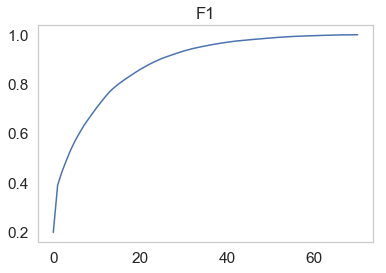

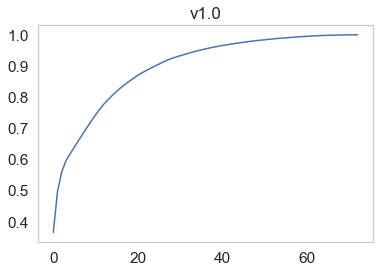

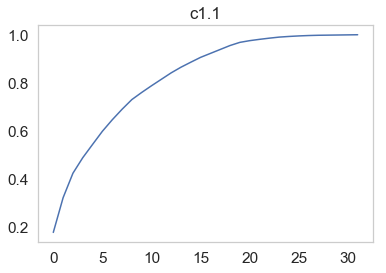

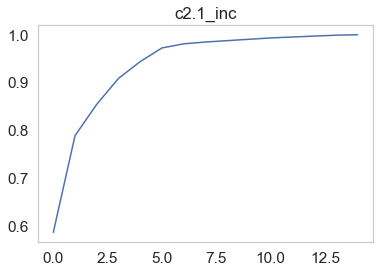

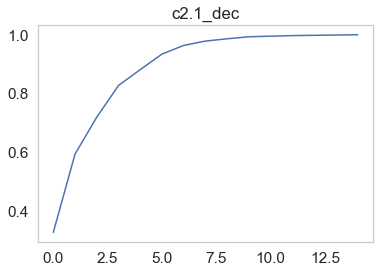

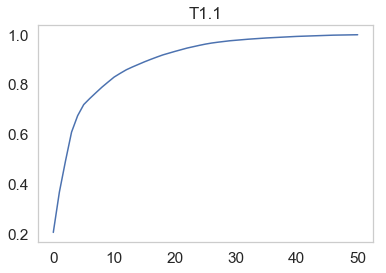

In [105]:
threshold = 0.90
exp_nums = ["F1", "v1.0", "c1.1", "c2.1_inc", "c2.1_dec", "T1.1"]
exps = [F1, v1, c1, c2_inc, c2_dec, T1]
strategies_set = set()
strategies = [F1_strategies, v1_strategies, c1_strategies, c2_inc_strategies, c2_dec_strategies, T1_strategies]
for exp_num, exp, S in zip(exp_nums, exps, strategies):
    exp.infer_strategies(precomputed_strategies=S, show_pids=False)
    strategy_proportions = exp.get_strategy_proportions()
    props = sorted(strategy_proportions.items(), key=operator.itemgetter(1), reverse=True)
    top_k_props = [p[1] for p in props]
    k_cumsum = np.cumsum(top_k_props)
    cutoff = 0
    for i, c in enumerate(k_cumsum):
        if c > threshold:
            cutoff = i
            break
    for p in props[:i+1]:
        strategies_set.add(p[0])
    print(exp_num, "Num strategies:", i+1)
    plt.figure()
    plt.title(exp_num)
    plt.plot(k_cumsum)
print(len(strategies_set))

Clusters: None 

Strategy transitions
(1, 0)
Number of significant transitions: 7
Number of insignificant transitions: 221
Alpha sidak: 0.0002249452854335976
Significant transitions: [((53, 53), (0.0, 0.0149), 17.13, 0.0), ((30, 30), (0.0377, 0.2789), 248.9, 0.0), ((21, 21), (0.2368, 0.1667), 17.43, 0.0), ((29, 29), (0.0412, 0.0), 47.99, 0.0), ((87, 87), (0.1553, 0.0491), 69.99, 0.0), ((56, 56), (0.0254, 0.0026), 21.43, 0.0), ((8, 8), (0.0, 0.0149), 17.13, 0.0)]


Strategy Transitions: Performance statistics
(1, 0)
Performance Increasing transitions []
Performance Decreasing transitions []
Constant transitions [((53, 53), (0.0, 0.0149), 17.13, 0.0), ((30, 30), (0.0377, 0.2789), 248.9, 0.0), ((21, 21), (0.2368, 0.1667), 17.43, 0.0), ((29, 29), (0.0412, 0.0), 47.99, 0.0), ((87, 87), (0.1553, 0.0491), 69.99, 0.0), ((56, 56), (0.0254, 0.0026), 21.43, 0.0), ((8, 8), (0.0, 0.0149), 17.13, 0.0)]


Strategy Transitions: Frequency statistics
(1, 0)
Frequency Increasing transitions [((53, 53), (

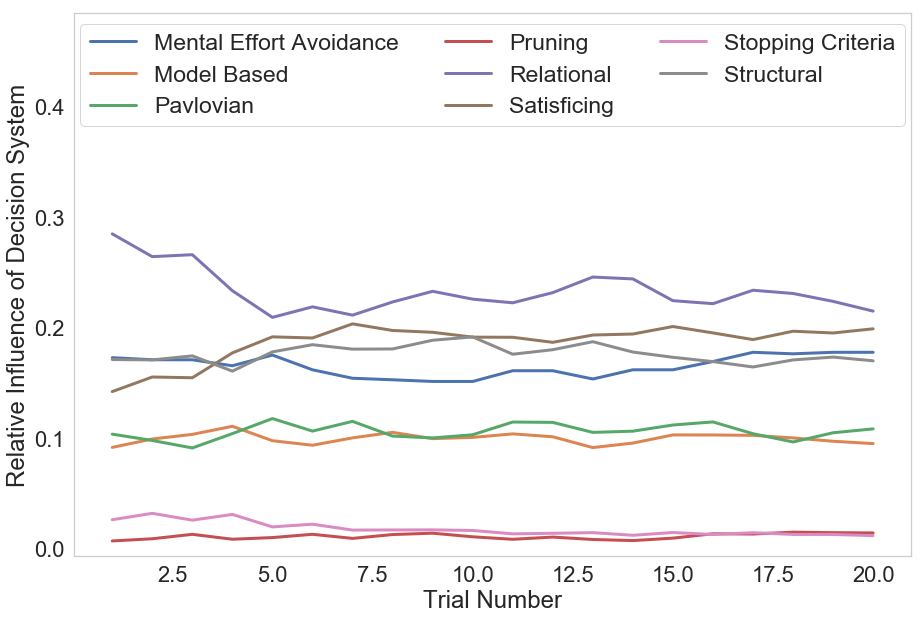

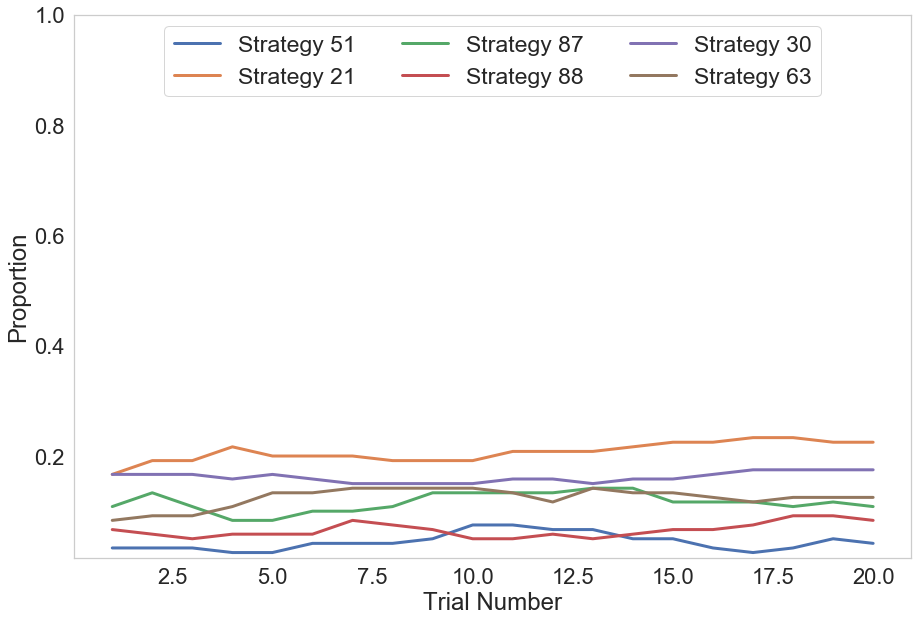

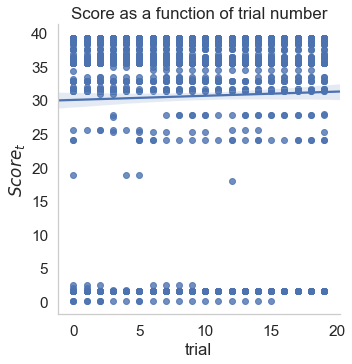

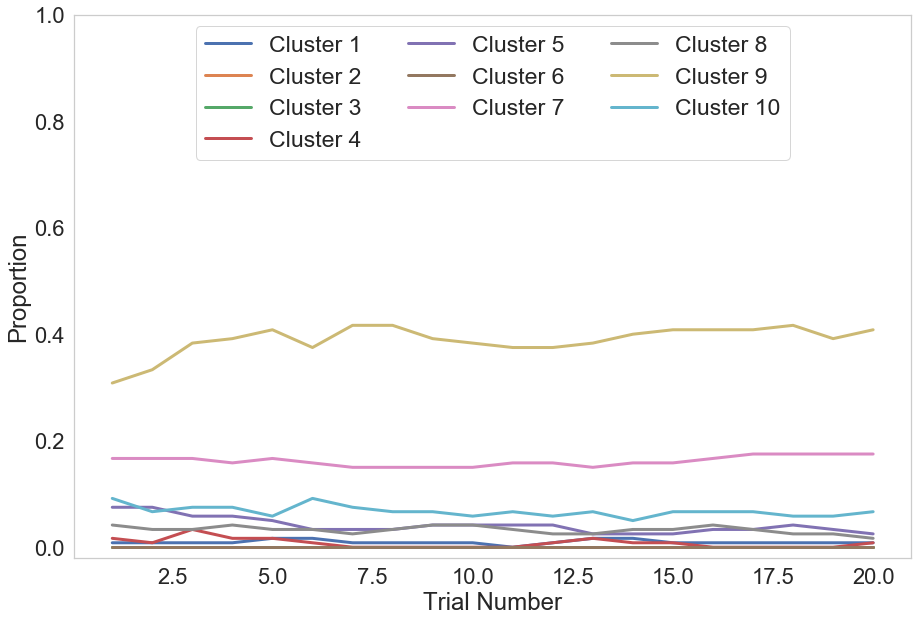

In [106]:
T1.summarize(features, normalized_features, strategy_weights, decision_systems, W_DS, DS_proportions, strategy_scores, cluster_scores, cluster_map, precomputed_strategies=T1_strategies, show_pids=False)

In [110]:
# E.plot_strategy_proportions(S = [21, 30])
# transition_frequencies = E.get_transition_frequencies()
# print(transition_frequencies)